# Uploading libraries

In [1]:
# Fundamental libraries

import os
import random
import time
import copy

# Working libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.autograd import Variable
from sklearn.metrics import classification_report
import torch.utils.data as data
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as transform
from torchvision.transforms.functional import convert_image_dtype
from PIL import Image
from transformers import AutoImageProcessor, ViTImageProcessor, ViTForImageClassification, ViTConfig, ResNetForImageClassification, ResNetConfig, BeitForImageClassification, BeitConfig, BeitImageProcessor, AutoFeatureExtractor
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from importlib import reload
import utility
reload(utility)
from utility import load_data, plot_confusion_matrix, plot_average_f1_scores, train_model, get_classification_details, get_hard_disk_path, show_samples, plot_features_importance, visualize_correlation, get_shap

# Evaluation
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# Model Recommendations
VGG-16: Despite being relatively deep, VGG-16 can still be effective on smaller datasets, especially when used with transfer learning. Its simplicity and well-understood architecture make it a good starting point.

ResNet-50: ResNet models, especially the shallower ones like ResNet-50, are known for their ability to avoid overfitting through the use of residual connections. This can be beneficial for learning from small datasets.

MobileNet: Designed for mobile and resource-constrained environments, MobileNets are lightweight and efficient, which can be advantageous when training data is limited.

SqueezeNet: This network achieves AlexNet-level accuracy with significantly fewer parameters. Its compact architecture makes it suitable for small datasets and limited computational resources.

# FILE PATHS on local environment

#### Each folder path represent class (label) :

**Folder name - calss name : description**

0 - 0 class : dead

1 - 1 class : empty

2 - 2 class : keep0

3 - 3 class : keep1

4 - 4 class : keep2

5 - 5 class : reseed0

6 - 6 class : reseed1

7 -  7 class : split

In [2]:
# paths for data upload
FILE_PATHS = ["E:/New_data_Maxim/new_architecture_2/DL1/", "E:/New_data_Maxim/new_architecture_2/DL2/", "E:/New_data_Maxim/new_architecture_2/DL3/"]

TRAIN_FEATURES_PATH_0 = FILE_PATHS[0] + 'keep0' 
TRAIN_FEATURES_PATH_1 = FILE_PATHS[0] + 'keep1'
TRAIN_FEATURES_PATH_2 = FILE_PATHS[0] + 'reseed0'

TRAIN_FEATURES_PATH_3 = FILE_PATHS[1] + 'keep1'
TRAIN_FEATURES_PATH_4 = FILE_PATHS[1] + 'keep2'
TRAIN_FEATURES_PATH_5 = FILE_PATHS[1] + 'reseed1'

TRAIN_FEATURES_PATH_6 = FILE_PATHS[2] + 'keep2'
TRAIN_FEATURES_PATH_7 = FILE_PATHS[2] + 'split'

# list with pathe
PATHES_LISTS = [[TRAIN_FEATURES_PATH_0,TRAIN_FEATURES_PATH_1,TRAIN_FEATURES_PATH_2],[TRAIN_FEATURES_PATH_3,TRAIN_FEATURES_PATH_4, TRAIN_FEATURES_PATH_5], [TRAIN_FEATURES_PATH_6, TRAIN_FEATURES_PATH_7]]

# Data set : train & test

The data was divided into training and testing sets for each class, with a split of 80% for training and 20% for testing, maintaining the same ratio for each class. However, the dataset exhibits an imbalance issue, with one class having a significantly larger number of samples compared to the other class.

In [3]:
labels = ['keep0', 'keep1', 'keep2', 'reseed0', 'reseed1', 'split']
for i, path in enumerate(PATHES_LISTS):
    print(path)

['E:/New_data_Maxim/new_architecture_2/DL1/keep0', 'E:/New_data_Maxim/new_architecture_2/DL1/keep1', 'E:/New_data_Maxim/new_architecture_2/DL1/reseed0']
['E:/New_data_Maxim/new_architecture_2/DL2/keep1', 'E:/New_data_Maxim/new_architecture_2/DL2/keep2', 'E:/New_data_Maxim/new_architecture_2/DL2/reseed1']
['E:/New_data_Maxim/new_architecture_2/DL3/keep2', 'E:/New_data_Maxim/new_architecture_2/DL3/split']


In [4]:
class CustomImageDataset_train(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths
        self.img_labels = img_labels
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)

        self.original_len = len(self.img_sort)

    def __len__(self):
        return self.original_len * 4

    def __getitem__(self, idx):
        original_idx = idx % self.original_len
        augmentation_index = idx // self.original_len

        # Load image
        img_path = self.img_sort[original_idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Apply augmentations
        image = self.augmentation(image, augmentation_index)

        # Process the image if a processor is set
        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        # Get label
        label = torch.tensor(self.img_labels[original_idx], dtype=torch.long)

        return image, label
        
    def augmentation(self, image, augmentation_index):
        # Random horizontal flipping
        flip_type = augmentation_index % 2  # 0 for horizontal, 1 for vertical
        rotation = (augmentation_index // 2) * 90  # Will give 0, 90, 180, 270

        # Apply flip
        if flip_type == 0:
            image = TF.hflip(image)
        else:
            image = TF.vflip(image)

        # Apply rotation
        image = TF.rotate(image, rotation)

        return image

### Separate data to train and test data with ratio 0.8 in test data

To utilize the CustomImageDataset_test and CustomImageDataset_train, it is necessary to specify the desired transformations for each case, such as Normalize and CenterCrop.

The following code demonstrates how to define the transformations:

For test data transformation using CenterCrop:

In [5]:
class CustomImageDataset_test(Dataset):
    def __init__(self, img_paths, img_labels, transform=None, model_name=None):
        self.img_sort = img_paths   # List of image paths
        self.img_labels = img_labels # Corresponding labels for each image
        self.transform = transform
        self.processor = None

        # Load the processor if a model name is given
        if model_name == "microsoft/resnet-50":
            self.processor = AutoImageProcessor.from_pretrained(model_name)
        if model_name == "microsoft/resnet-18":
            self.processor = AutoFeatureExtractor.from_pretrained(model_name)
        if model_name == "microsoft/beit-base-patch16-224-pt22k-ft22k":
            self.processor = BeitImageProcessor.from_pretrained(model_name)
        if model_name == "google/vit-base-patch16-224":
            self.processor = ViTImageProcessor.from_pretrained(model_name)
        
        self.len = len(self.img_sort)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img_path = self.img_sort[idx]
        try:
            PIL_image = Image.open(img_path).convert("L")

            # The image can be converted to tensor using
            image = transform.to_tensor(PIL_image)
            image = image * 255
            image = image.type(torch.uint8)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            # Handle error (e.g., by skipping this sample or using a default image)

        label = torch.tensor(self.img_labels[idx], dtype=torch.long)
        
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
            
        if self.transform:
            image = self.transform(image)

        if self.processor:
            image = self.processor(images=image, return_tensors="pt").pixel_values.squeeze()

        return image, label

In [7]:
import torch
import wandb
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
import csv

model_names = ["microsoft/resnet-50", "microsoft/resnet-18", "microsoft/beit-base-patch16-224-pt22k-ft22k", "google/vit-base-patch16-224"]

for FILE_PATH in FILE_PATHS:
    if "DL1" in FILE_PATH:
        all_labels_list = ['keep0', 'keep1', 'reseed0']
        PATHES_LIST = PATHES_LISTS[0]
    elif "DL2" in FILE_PATH:
        PATHES_LIST = PATHES_LISTS[1]
        all_labels_list = ['keep1', 'keep2', 'reseed1']
    elif "DL3" in FILE_PATH:
        PATHES_LIST = PATHES_LISTS[2]
        all_labels_list = ['keep2', 'split']
    for model_name in model_names:
        # Initialize a new wandb run
        wandb.init(project="organoid_classification", entity="laurent-gurtler")

        num_epochs = 2
        learning_rate = 5e-5
        batch_size = 64
        k_folds = 2
        weight_decay = 1e-5

        config = wandb.config
        config.learning_rate = learning_rate
        config.batch_size = batch_size
        config.num_epochs = num_epochs
        config.k_folds = k_folds
        config.weight_decay = weight_decay

        all_fold_f1_scores = []
        num_labels = len(all_labels_list)  # The number of unique labels/classes in your dataset

        # Assuming PATHES_LIST contains paths to your different class directories
        img_labels = []
        img_sort = []
        for i, img_dir in enumerate(PATHES_LIST):
            img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
            img_labels.extend([i] * len(img_files))  # Labels for each image
            img_sort.extend([os.path.join(img_dir, f) for f in img_files])  # Paths for each image

        # Convert img_sort to a numpy array for easier indexing
        img_sort = np.array(img_sort)

        # Initialize StratifiedKFold
        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Convert img_labels to numpy array for StratifiedKFold
        img_labels = np.array(img_labels)

        for fold, (train_idx, val_idx) in enumerate(kf.split(img_sort, img_labels)):
            print(f"Training on fold {fold+1}/{k_folds}")
            if "beit" in model_name:
                config = BeitConfig.from_pretrained(model_name, num_labels=num_labels)
                model = BeitForImageClassification(config)
            elif "resnet" in model_name:
                config = ResNetConfig.from_pretrained(model_name, num_labels=num_labels)
                model = ResNetForImageClassification(config)
            elif "vit" in model_name:
                config = ViTConfig.from_pretrained(model_name, num_labels=num_labels)
                model = ViTForImageClassification(config)
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Split data into training and validation for this fold
            train_data = img_sort[train_idx]
            val_data = img_sort[val_idx]

            # Create datasets for this fold
            train_dataset = CustomImageDataset_train(train_data, img_labels[train_idx], 
                                                    transform=False, 
                                                    model_name=model_name)
            test_dataset = CustomImageDataset_test(val_data, img_labels[val_idx], 
                                                transform=False, 
                                                model_name=model_name)
            

            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(device)
            model.to(device)

            wandb.watch(model, criterion, log="all", log_freq=10)

            epoch_f1_scores_dict_list = []

            num_images_displayed = 0

            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for images, labels in train_loader:
                    if num_images_displayed < 5:  # Change 5 to however many batches you want to visualize
                        img = images[0].cpu().numpy()
                        img = np.transpose(img, (1,2,0))
                        img = np.clip(img,0,1)
                        plt.imshow(img)
                        plt.show()  # Display the first image in the batch
                        num_images_displayed += 1
                    images = images.to(device)
                    labels = labels.to(device)  # Convert labels to torch.long
                    optimizer.zero_grad()
                    outputs = model(images).logits
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                
                wandb.log({"fold": fold+1, "epoch": epoch, "train_loss": running_loss/len(train_loader)})

                # Validation phase
                model.eval()
                all_labels = []
                all_predictions = []
                validation_loss = 0.0
                correct = 0
                total = 0

                with torch.no_grad():
                    for images, labels in test_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images).logits
                        predicted = outputs.argmax(dim=1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        loss = criterion(outputs, labels)
                        validation_loss += loss.item()

                        # Move the labels and predictions to CPU for sklearn metrics
                        all_labels.extend(labels.cpu().numpy())
                        all_predictions.extend(predicted.cpu().numpy())

                # Calculate accuracy and F1 score
                accuracy = 100 * correct / total
                f1_scores = f1_score(all_labels, all_predictions, average=None, zero_division=0)  # This will give you an array of F1 scores per class
                # Check if the length of F1 scores matches the number of labels
                if len(f1_scores) != len(all_labels_list):
                    print(f"Warning: Number of F1 scores ({len(f1_scores)}) does not match number of classes ({len(all_labels_list)})")
                    # Trim the list of F1 scores to match the number of classes, if necessary
                    f1_scores = f1_scores[:len(all_labels_list)]

                # Create a dictionary of class labels and their corresponding F1 scores
                f1_scores_dict = {all_labels_list[idx]: f1 for idx, f1 in enumerate(f1_scores)}
                epoch_f1_scores_dict_list.append(f1_scores_dict)

                # It might be useful to also get the classification report for all metrics
                classification_rep = classification_report(all_labels, all_predictions, output_dict=True, zero_division=0)

                # Logging the individual F1 scores
                for idx, f1 in enumerate(f1_scores):
                    wandb.log({f"class_{idx}_f1_score": f1})


                wandb.log({"fold": fold+1, "epoch": epoch, "val_loss": validation_loss/len(test_loader), "val_accuracy": accuracy})

                # Print statistics for each class
                print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, "
                    f"Validation Loss: {validation_loss/len(test_loader)}, Accuracy: {accuracy} %")
                for idx, f1 in enumerate(f1_scores):
                    print(f"Class {idx} F1 Score: {f1}")

                for idx, f1 in enumerate(f1_scores):
                    wandb.log({f"class_{idx}_f1_score": f1})

            # Access the F1-scores for the last epoch
                # Access the F1-scores for the last epoch of this fold
            last_epoch_f1_scores = epoch_f1_scores_dict_list[-1]

            # Append model name, fold number, and F1 scores to the list
            fold_data = {"model_name": model_name, "fold": fold + 1}
            fold_data.update(last_epoch_f1_scores)
            all_fold_f1_scores.append(fold_data)

            # Clear the epoch_f1_scores_dict_list for the next fold
            epoch_f1_scores_dict_list.clear()

            # The last_epoch_f1_scores already contains the F1 scores for each class from the last epoch
            # Optionally, you can directly plot these scores if needed
            plot_average_f1_scores(all_labels_list, last_epoch_f1_scores)


            # After the loop, you may want to log the overall performance
            wandb.log({
                "fold": fold+1, "final_accuracy": accuracy,
                "fold": fold+1, "final_f1_scores": f1_scores.tolist(),  # Convert to list if necessary
                "fold": fold+1, "final_classification_report": classification_rep
            })

            csv_filename = FILE_PATH + 'f1_scores_per_fold.csv'
            existing_data = []

            # Read existing data
            if os.path.exists(csv_filename):
                with open(csv_filename, 'r') as file:
                    reader = csv.DictReader(file)
                    existing_data = [row for row in reader]

            # Update or append new data
            for new_data in all_fold_f1_scores:
                model_found = False
                for existing_row in existing_data:
                    if existing_row['model_name'] == new_data['model_name'] and existing_row['fold'] == str(new_data['fold']):
                        # Update existing row with new data
                        for key, value in new_data.items():
                            existing_row[key] = value
                        model_found = True
                        break
                if not model_found:
                    # Convert numeric values to strings for CSV writing
                    new_data_string = {k: str(v) for k, v in new_data.items()}
                    existing_data.append(new_data_string)

            # Write updated data back to CSV
            header = ['model_name', 'fold'] + all_labels_list

            with open(csv_filename, 'w', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=header)
                writer.writeheader()
                for data_row in existing_data:
                    writer.writerow(data_row)

        # Close the wandb run
        wandb.finish()


['E:/New_data_Maxim/new_architecture_2/DL1/keep0', 'E:/New_data_Maxim/new_architecture_2/DL1/keep1', 'E:/New_data_Maxim/new_architecture_2/DL1/reseed0']


NameError: name 'all_labels_list' is not defined

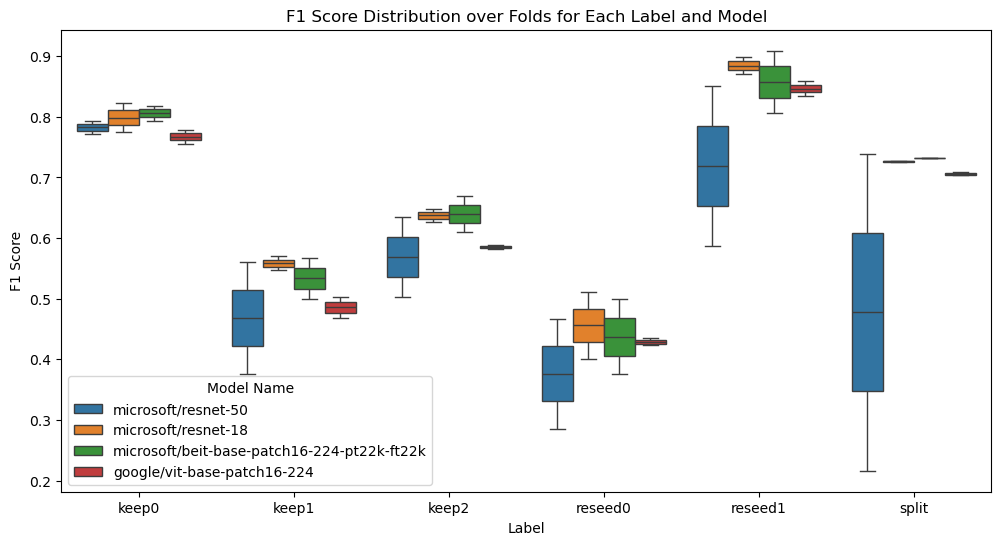

In [73]:
import seaborn as sns

df = pd.read_csv(csv_filename)
df_long = df.melt(id_vars=['model_name', 'fold'], 
                  value_vars=all_labels_list,  # list all your label columns here
                  var_name='label', value_name='f1_score')
# Creating a boxplot for each label within each model
plt.figure(figsize=(12, 6))

# You might need to adjust the size of the figure based on the number of models and labels
sns.boxplot(x='label', y='f1_score', hue='model_name', data=df_long)

plt.title('F1 Score Distribution over Folds for Each Label and Model')
plt.xlabel('Label')
plt.ylabel('F1 Score')
plt.legend(title='Model Name')
plt.show()